In [ ]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
idx = pd.IndexSlice
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
tickers = [
    'HINDUNILVR.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'ITC.NS', 'COLPAL.NS', 'PGHH.NS', 'DABUR.NS', 'MARICO.NS', 'GODREJCP.NS', 'TATACONSUM.NS'
]

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(tickers, start="2022-01-01", end="2023-01-01")['Adj Close']
close = yf.download(tickers, start="2022-01-01", end="2023-01-01")['Adj Close']
train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)



[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


Text(0.5, 1.0, 'Assets Correlation Matrix')

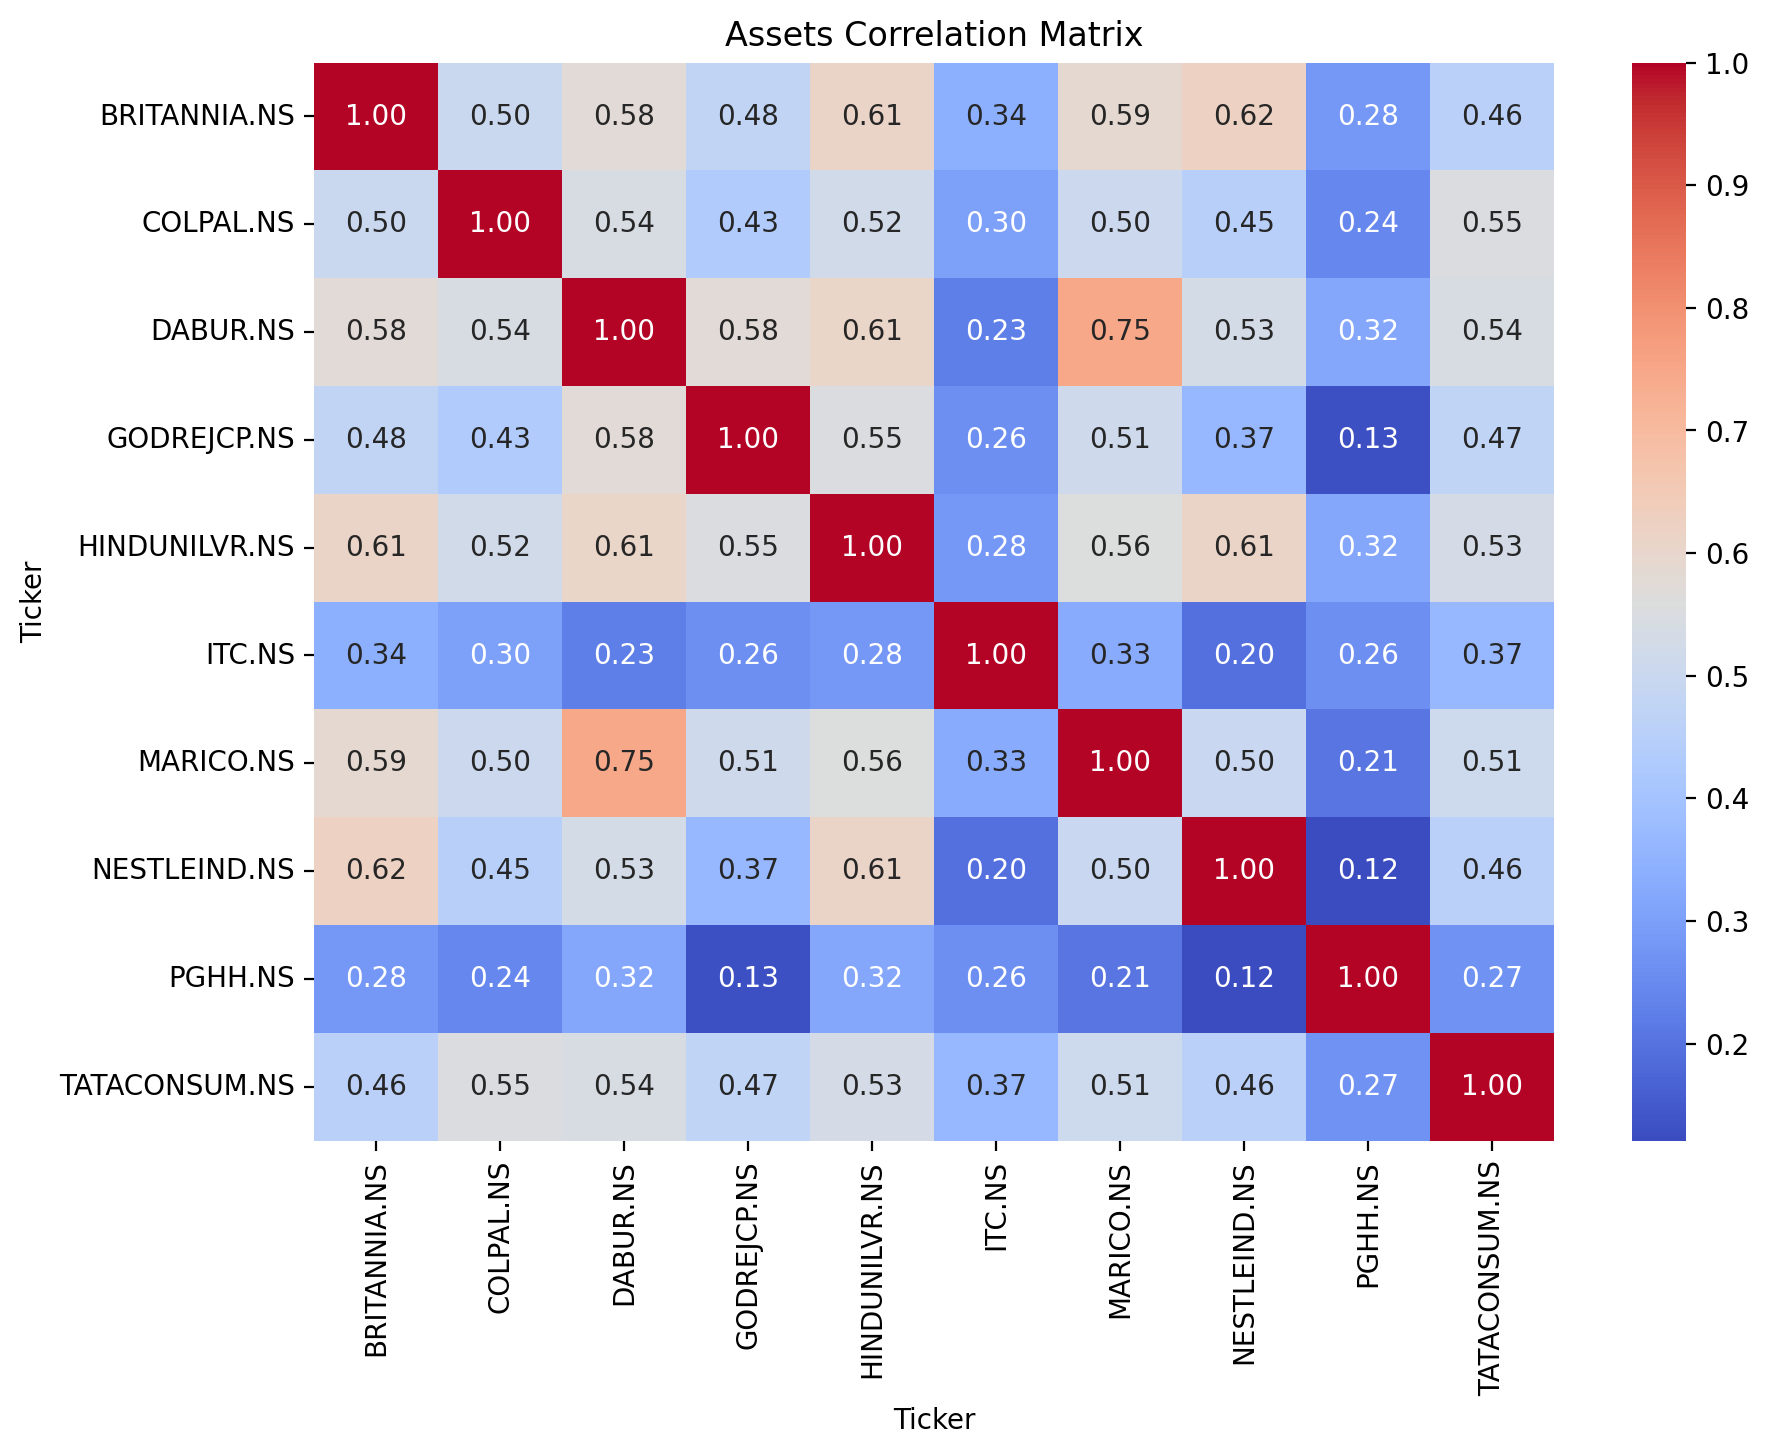

In [ ]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')



In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs


[('DABUR.NS', 'PGHH.NS')]


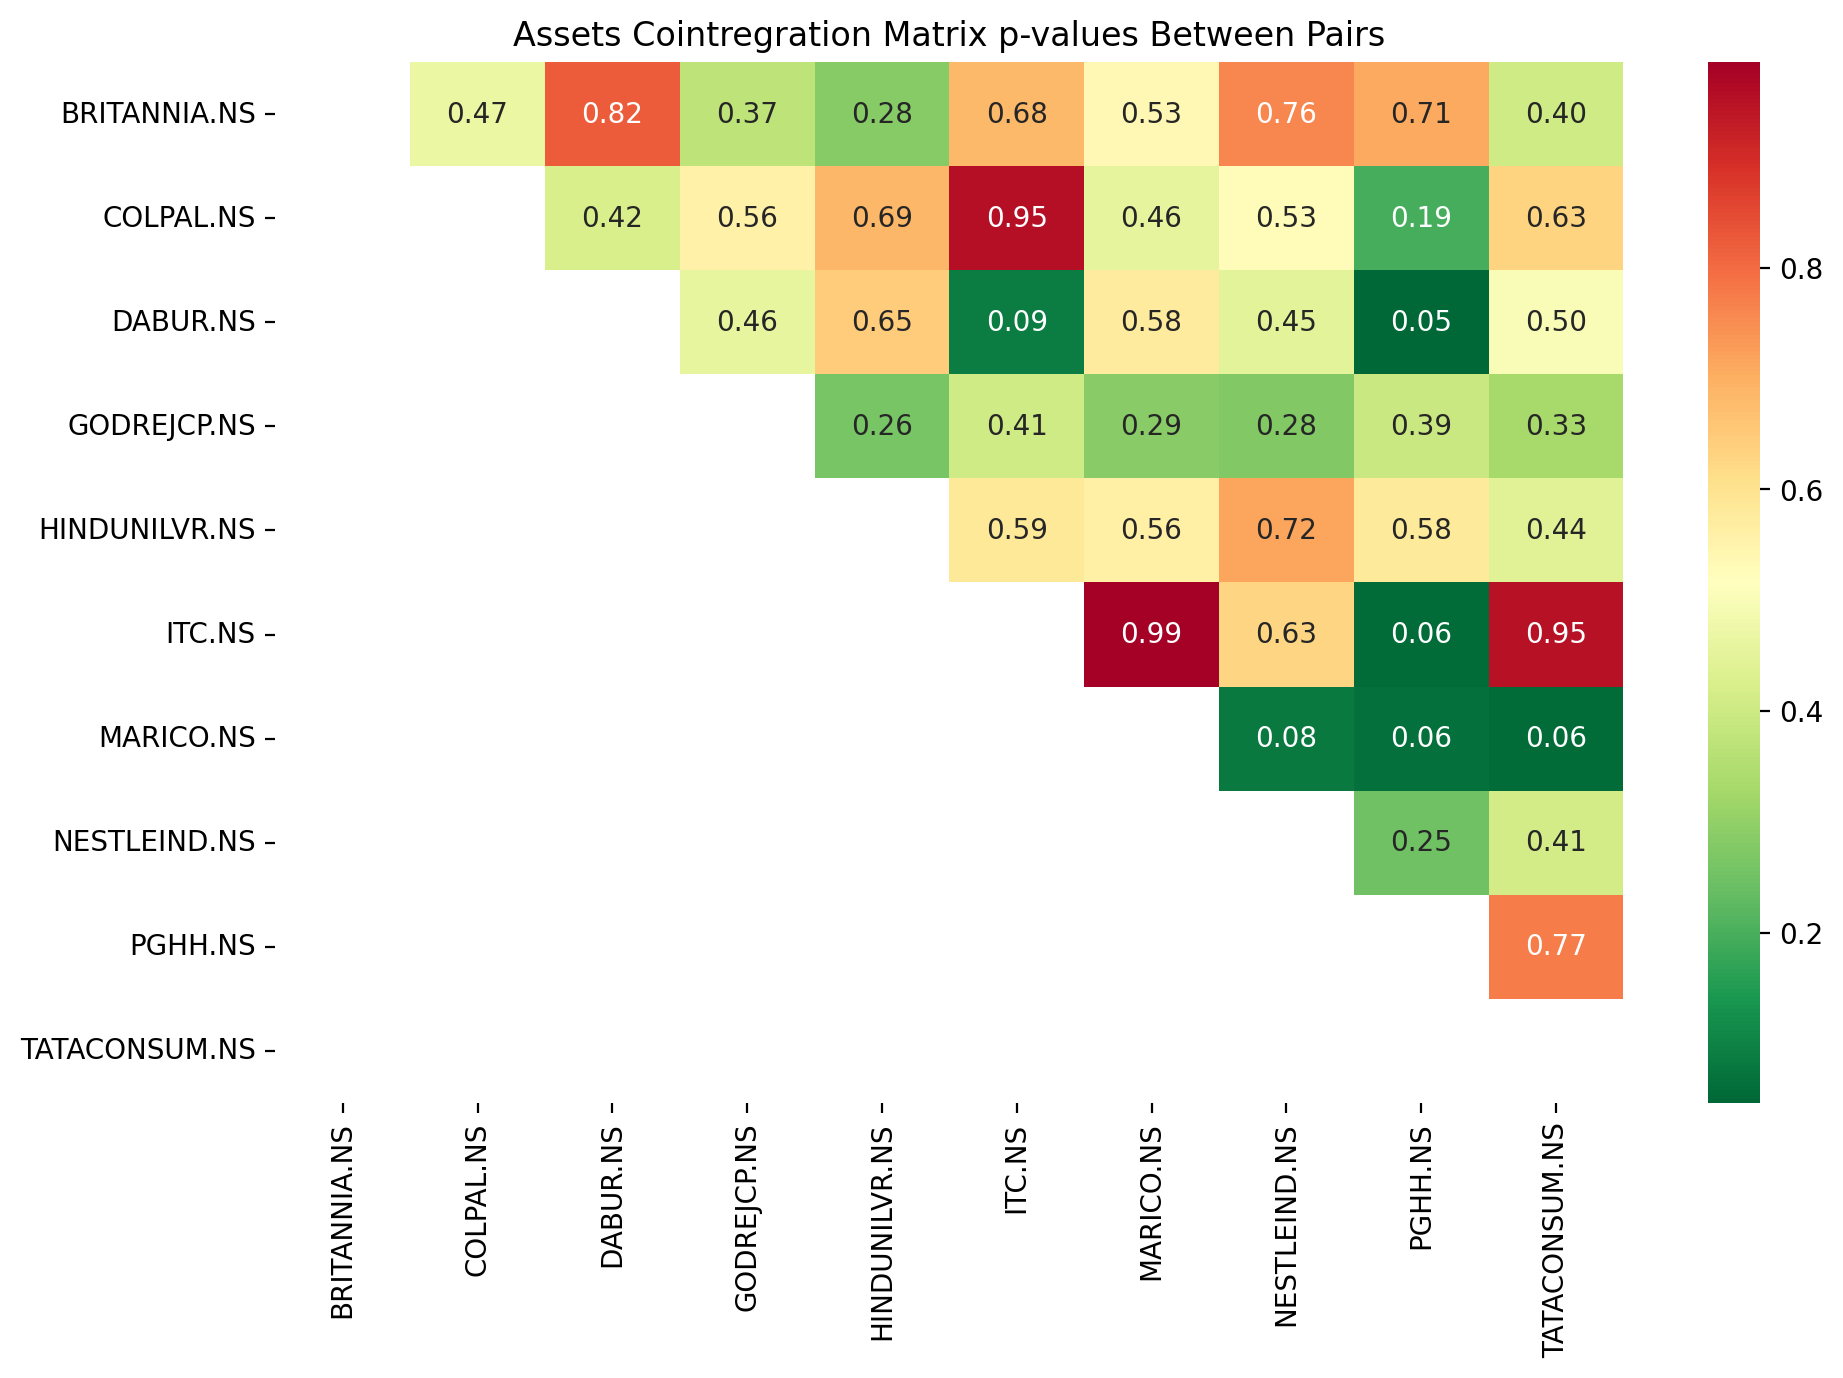

In [ ]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()


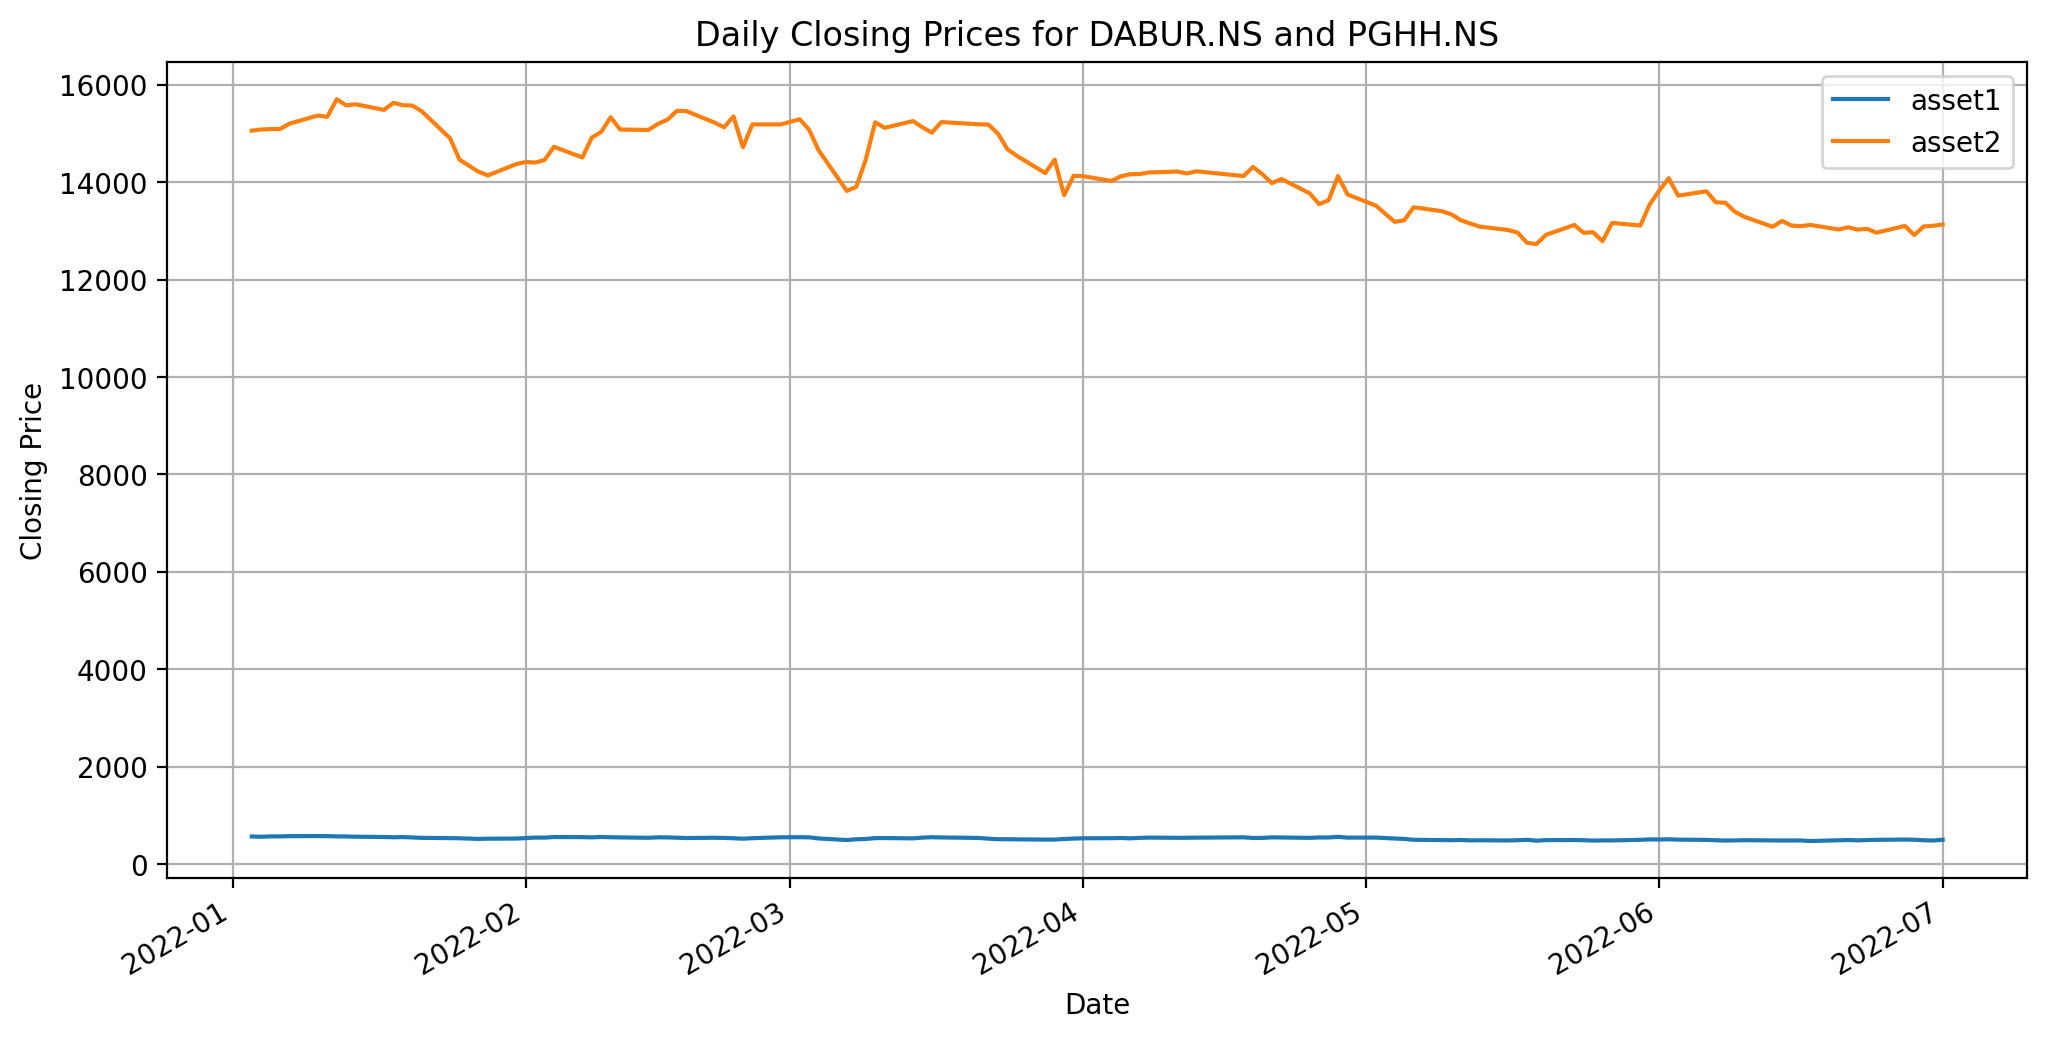

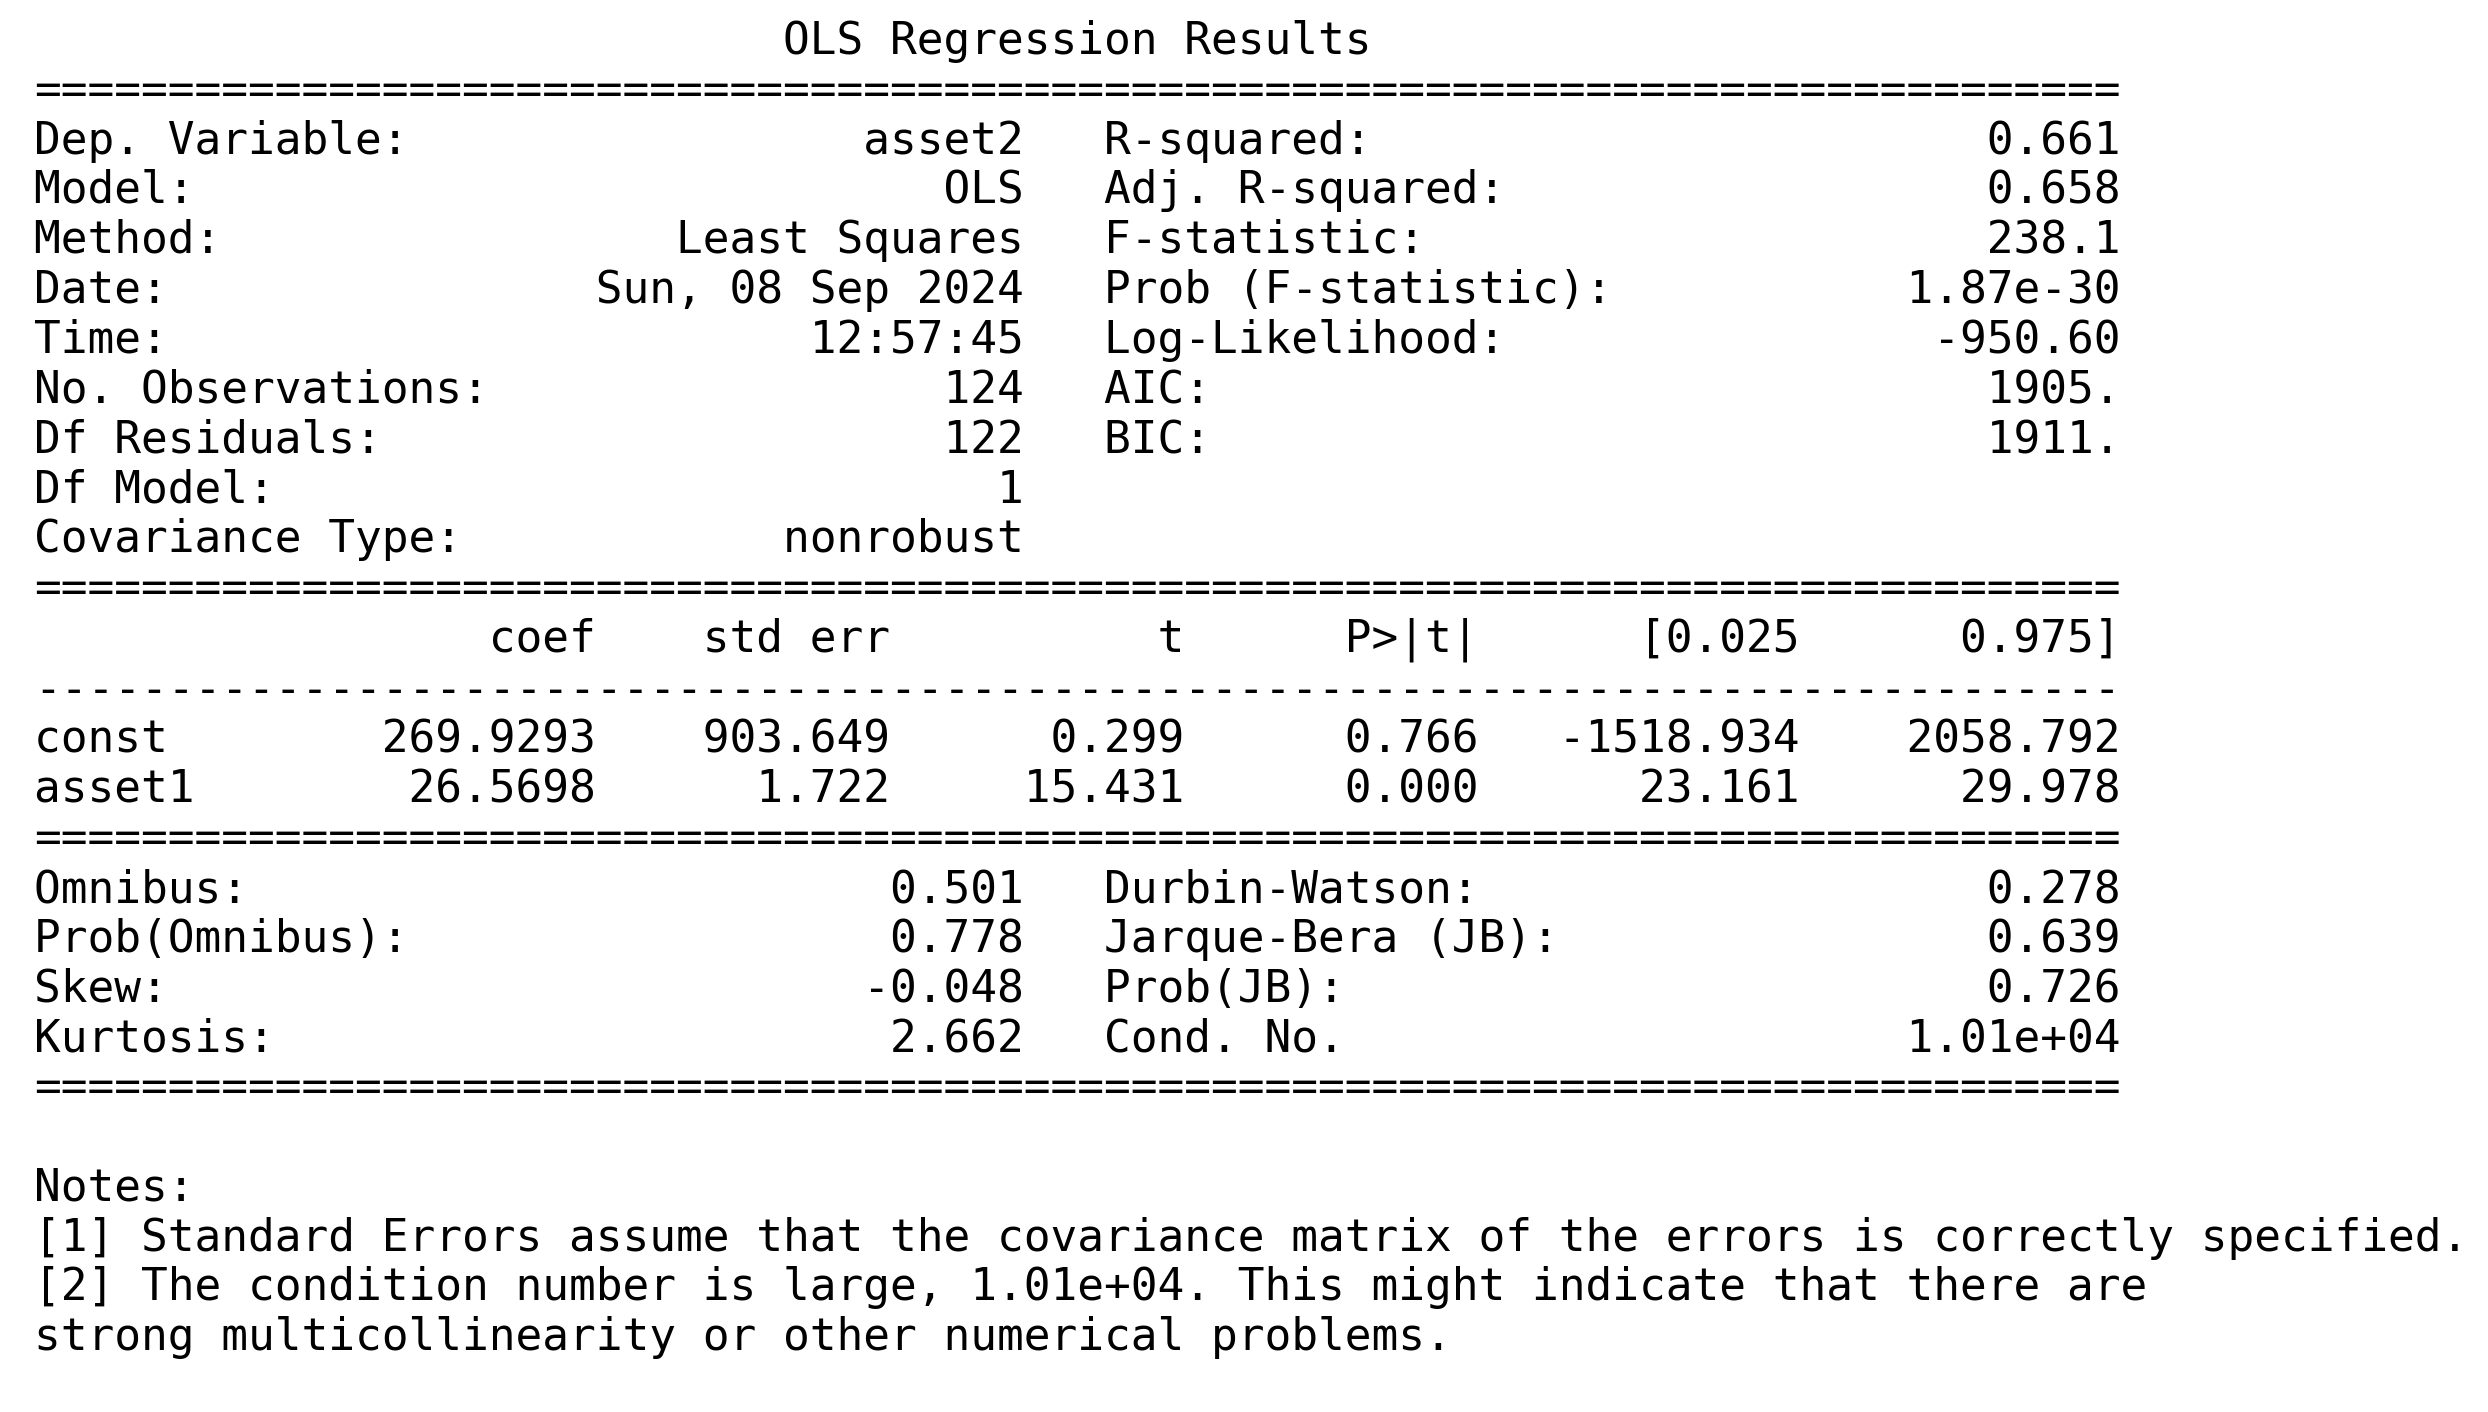

<ipython-input-7-d1c8f05c8bcd>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Hedge Ratio = ', model.params[1])
<ipython-input-7-d1c8f05c8bcd>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = train.asset2 - model.params[1] * train.asset1


Hedge Ratio =  26.569830455851495


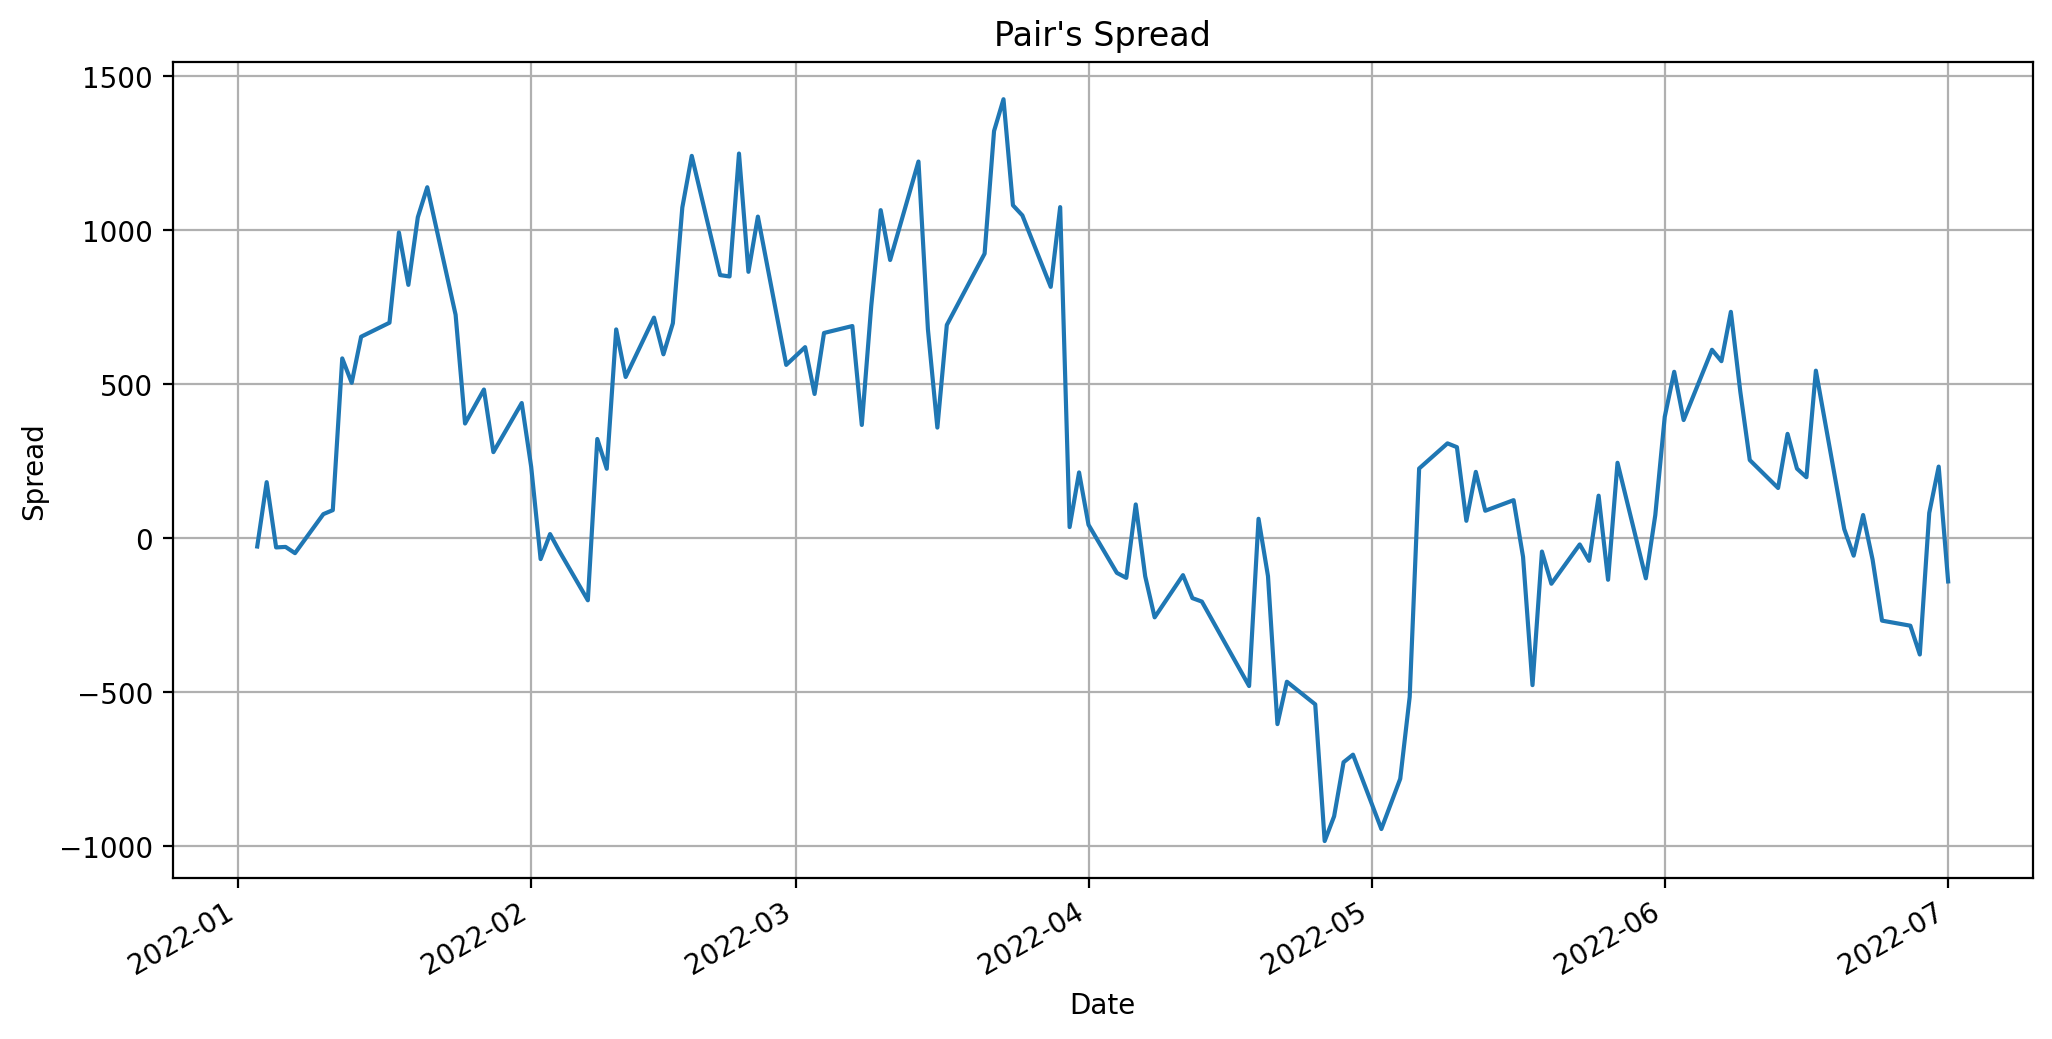

ADF Statistic =  -2.3785933831027206
p-value =  0.14786963812925163
Critical Values =  {'1%': -3.4851223522012855, '5%': -2.88553750045158, '10%': -2.5795685622144586}


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Assuming you have the 'train_close' DataFrame with the closing prices of all assets

# Final pair to test the strategy
asset1 = 'DABUR.NS'
asset2 = 'PGHH.NS'

# Create a train DataFrame of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

# Visualize closing prices
ax = train[['asset1', 'asset2']].plot(figsize=(12, 6), title='Daily Closing Prices for {} and {}'.format(asset1, asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

plt.show()  # Show the plot before proceeding

# Run OLS regression
model = sm.OLS(train.asset2, sm.add_constant(train.asset1)).fit()

# Print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties='monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

plt.show()  # Show the plot before proceeding

print('Hedge Ratio = ', model.params[1])

# Calculate spread
spread = train.asset2 - model.params[1] * train.asset1

# Plot the spread
ax = spread.plot(figsize=(12, 6), title="Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True)

plt.show()  # Show the plot before proceeding

# Conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag=1)
print('ADF Statistic = ', adf[0])
print('p-value = ', adf[1])
print('Critical Values = ', adf[4])


                               asset1        asset2         z  z upper limit  \
Date                                                                           
2022-07-04 00:00:00+00:00  512.851807  13445.822266 -1.350629            1.0   
2022-07-05 00:00:00+00:00  518.419922  13529.778320 -1.205623            1.0   
2022-07-06 00:00:00+00:00  530.386414  13798.313477 -1.104837            1.0   
2022-12-28 00:00:00+00:00  561.177551  13928.598633  0.430185            1.0   
2022-12-29 00:00:00+00:00  553.092407  14184.206055 -0.644566            1.0   
2022-12-30 00:00:00+00:00  553.585388  14315.135742 -0.911756            1.0   

                           z lower limit  signals1  positions1  signals2  \
Date                                                                       
2022-07-04 00:00:00+00:00           -1.0         1         NaN        -1   
2022-07-05 00:00:00+00:00           -1.0         1         0.0        -1   
2022-07-06 00:00:00+00:00           -1.0         1     

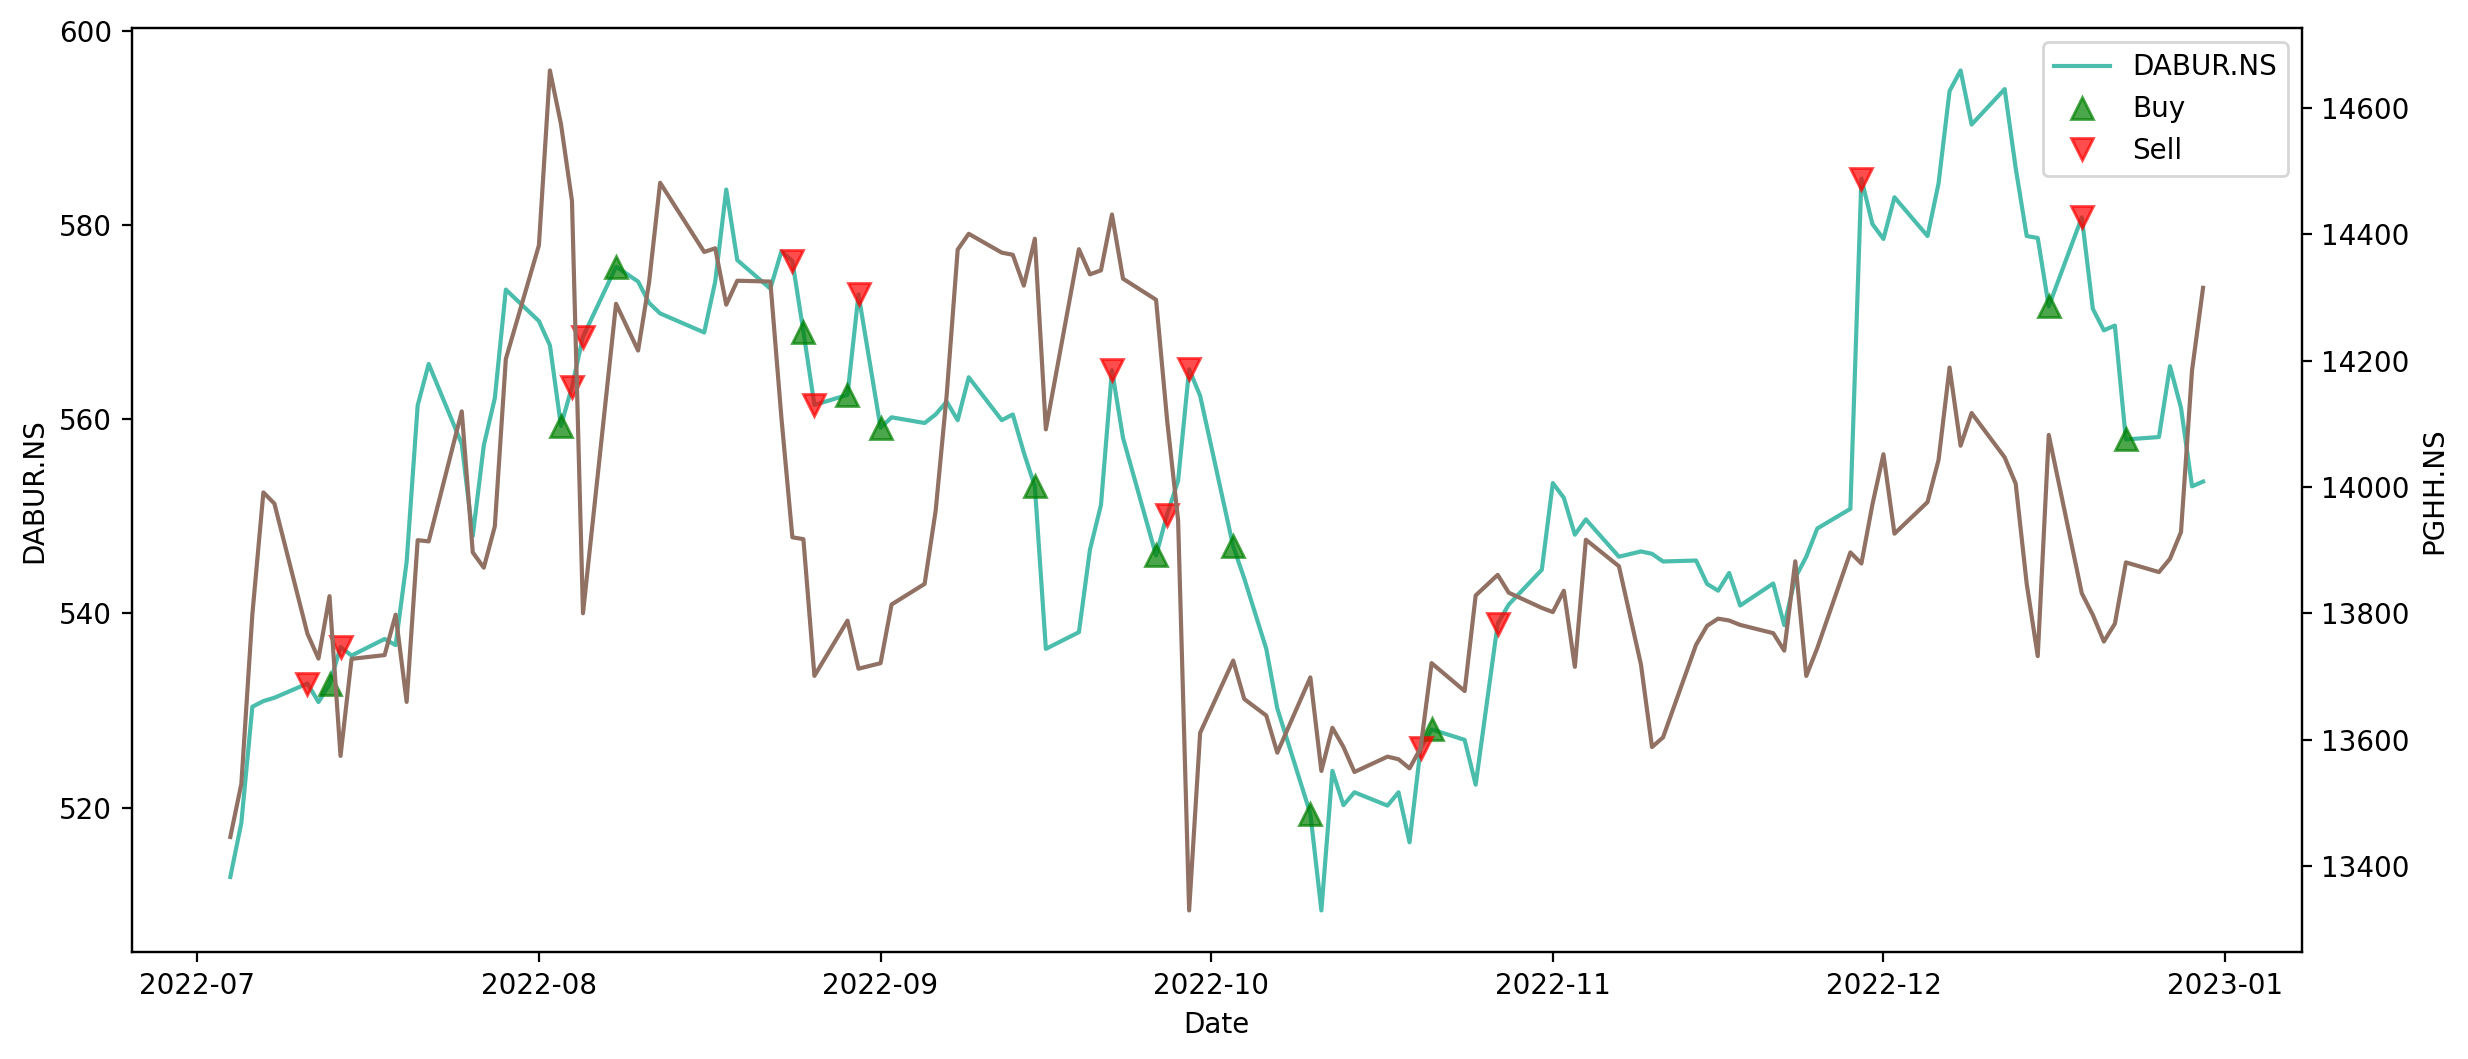

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1]
signals['asset2'] = test_close[asset2]

# Calculate ratios and z-score
ratios = signals.asset1 / signals.asset2
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# Create trading signals: short if z > upper limit, long if z < lower limit
signals['signals1'] = np.select([signals['z'] > signals['z upper limit'],
                                 signals['z'] < signals['z lower limit']],
                                [-1, 1], default=0)

# Calculate positions based on signals
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# Verify head and tail of DataFrame
print(pd.concat([signals.head(3), signals.tail(3)]))

# Visualize trading signals and positions
fig = plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)
bx2 = bx.twinx()

# Plot the two assets
l1, = bx.plot(signals['asset1'], c='#4abdac', label=asset1)
l2, = bx2.plot(signals['asset2'], c='#907163', label=asset2)

# Plot buy signals (upward marker)
bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g', alpha=0.7, label='Buy')

# Plot sell signals (downward marker)
bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0, marker='v', markersize=8, c='r', alpha=0.7, label='Sell')

# Adding labels and legend
bx.set_xlabel('Date')
bx.set_ylabel(asset1)
bx2.set_ylabel(asset2)
bx.legend(loc='best')

plt.show()


Number of days =  177
CAGR = 448.921%


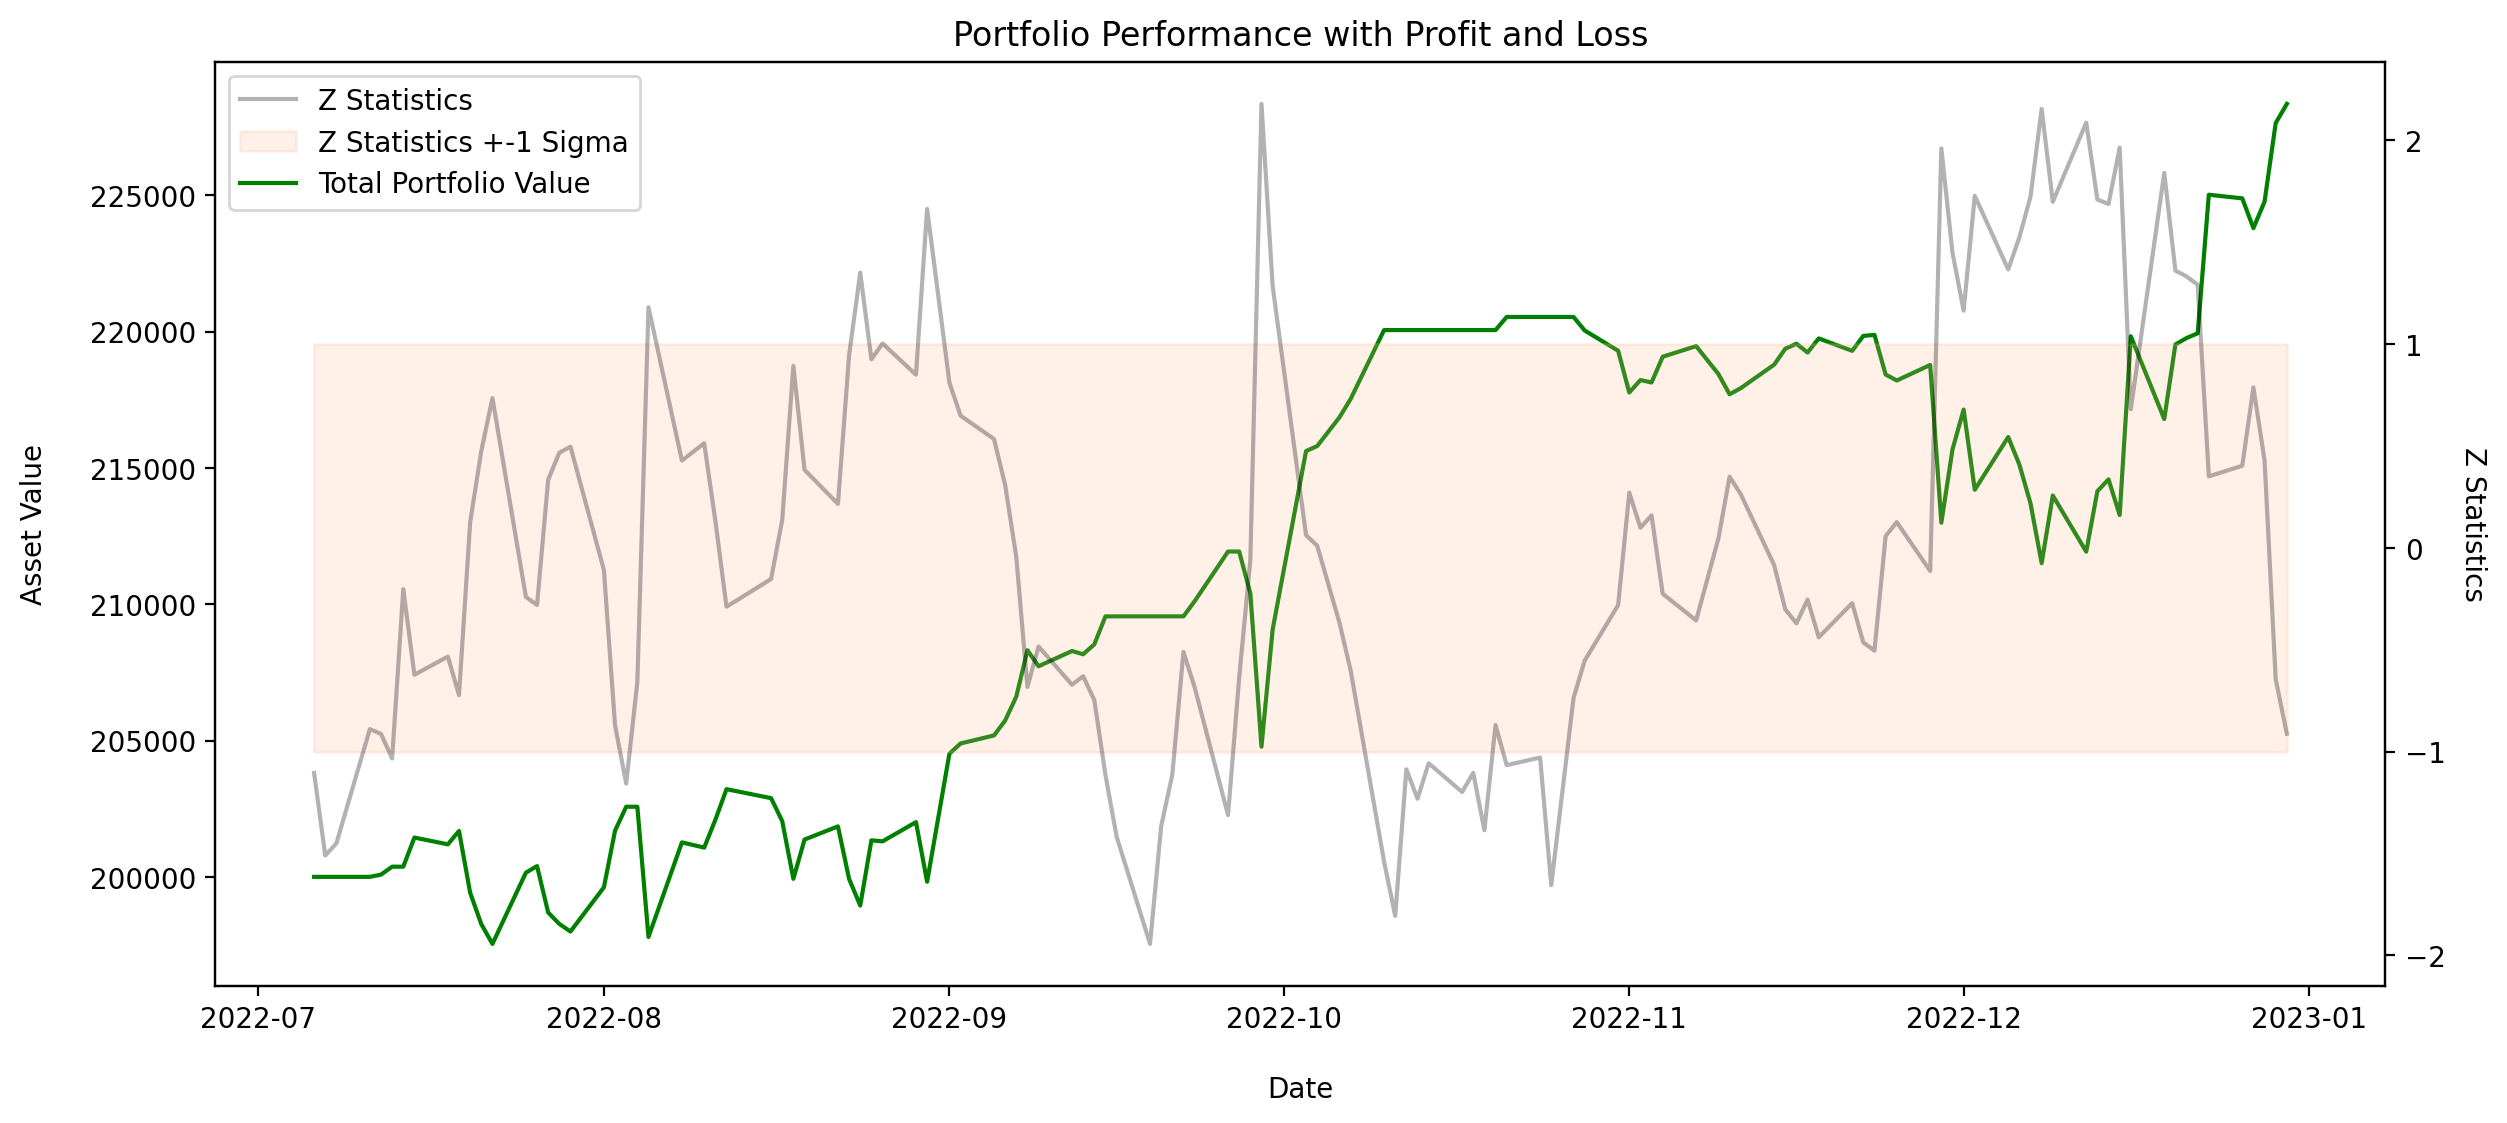

In [ ]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');


# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))
